# Pump Design Iteration

In [2]:
import math
import CoolProp.CoolProp as CP      # import CoolProp

# TBD
k_s = 10*1e-6 # superficial roughness

rho = 728.53 # [kg/m^3] fluid density (1)
g = 9.81 # [m/s^2]

T1 = 90 # [K] inlet temperature (2)
m_dot = 0.2582 # [kg/s] mass flow rate (3)
V = m_dot/rho # [m^3/s] volumetric flow rate (3)

pt1 = 3.38*1e5 # [Pa] inlet total pressure (4)
pt3 = 31.47*1e5 # [Pa] outlet total pressure (5)
dtp = pt3 - pt1 # total pressure difference [Pa]

# Z_h = 1 # [m] head lossS
# W_ref = g*dH # [J/kg] reversible work
# E_diss = g*Z_h # [J/kg] dissipation
# W = W_ref + E_diss # [J/kg]
#eta_hyd = W_ref/W # [-] hydraulic (reversible) efficiency

n = 36137 # [rpm] speed of rotation
z = 2 # [-] number of stages

vanes = True # vaned (True) or vaneless diffuser (False)

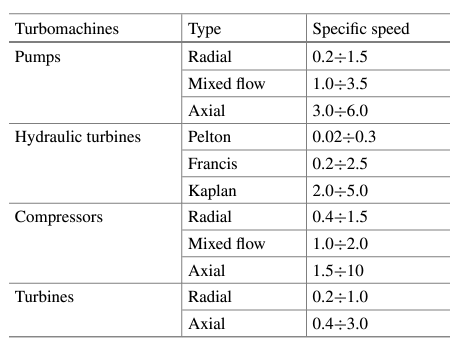 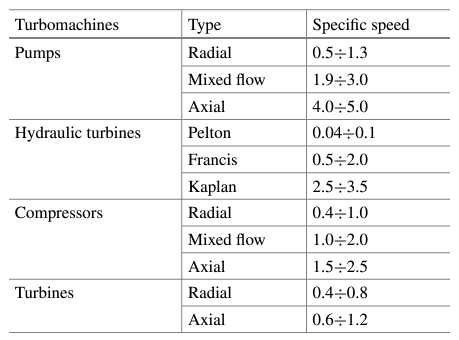

## Kinematic Parameters


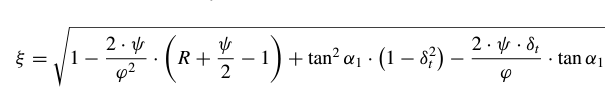

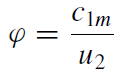 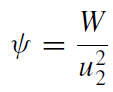 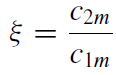 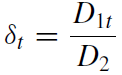

In [3]:
def kinParam(eta_hyd, psi, phi, R, delta_h, alpha_1, c_1):
    W = (g*dHs)/eta_hyd #Stage work [J/kg]
    u_2 = math.sqrt(W/psi) # blade speed at rotor outlet

    D_2 = (60*u_2)/(math.pi*n) #Rotor outlet diameter
    print('D_2: ', D_2)

    if set_c_1 == True:
        phi = c_1/(u_2*math.sqrt(1+(math.tan(alpha_1)**2)))
        print('phi: ', phi)

    delta_t = math.sqrt((delta_h**2)+((4*V)/(math.pi*phi*u_2*(D_2)**2))) #Rotor tip diameter ratio
    xi = math.sqrt(1-((2*psi)/phi**2)*(R+(psi/2)-1)+(math.tan(alpha_1)**2)*(1-delta_t**2)-((2*psi*delta_t)/phi)*math.tan(alpha_1)) #Rotor meridional velocity ratio

    #Flow angles
    alpha_2 = math.atan((psi/(xi*phi))+((delta_t/xi)*math.tan(alpha_1)))
    beta_1 = math.atan((delta_t/phi)-math.tan(alpha_1))
    beta_2 =math.atan(((1/(phi*xi))*(1-psi))-((delta_t/xi)*math.tan(alpha_1)))

    # Kinematic parameters
    c_1m = u_2*phi
    c_1u = u_2*phi*math.tan(alpha_1)
    c_2m = u_2*xi*phi
    c_2u = u_2*xi*phi*math.tan(alpha_2)
    w_1u = u_2*phi*math.tan(beta_1)
    w_2u = u_2*xi*phi*math.tan(beta_2)
    c_1 = u_2*phi*math.sqrt(1+(math.tan(alpha_1)**2))
    c_2 = u_2*xi*phi*math.sqrt(1+(math.tan(alpha_2)**2))
    print('c_2: ', c_2)
    w_1 = u_2*phi*math.sqrt(1+(math.tan(beta_1)**2))
    w_2 = u_2*xi*phi*math.sqrt(1+(math.tan(beta_2)**2))
    u_1 = u_2*delta_t

    c_3 = c_1
    print('set c_3 = c_1 =', c_3)

    return {'D_2': D_2, 'delta_t': delta_t, 'xi': xi, 'alpha_2': alpha_2,
            'beta_1': beta_1, 'beta_2': beta_2, 'c_1m': c_1m, 'c_1u': c_1u ,
            'c_2m': c_2m, 'c_2u': c_2u, 'w_1u': w_1u, 'w_2u': w_2u, 'c_1': c_1,
            'c_2': c_2, 'w_1': w_1, 'w_2': w_2, 'u_1': u_1, 'u_2': u_2, 'W': W,
            'c_3': c_3, 'phi': phi}

## Geometric parameters
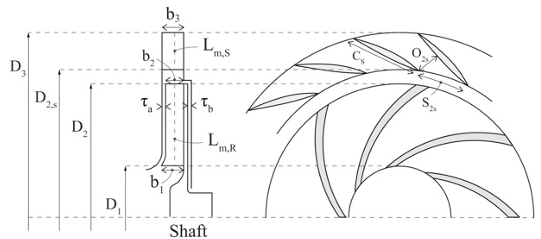 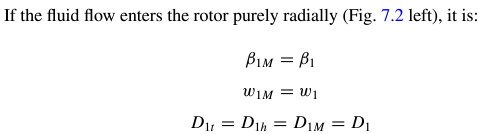

### Rotor geometry

In [4]:
def rotorGeo(c_1m, c_2m, D_2, delta_t, xi, beta_2, alpha_2):

    # flow areas
    A_1 = V/c_1m
    A_2 = V/c_2m

    b_2 = A_2/(math.pi*D_2) # blade height at rotor outlet
    print('b_2:', b_2)

    D_1h = delta_h*D_2
    print('D_1h:', D_1h)
    D_1t = delta_t*D_2
    print('D_1t:', D_1t)

    D_1M = (D_1t+D_1h)/2 # inlet mean diameter
    print('D_1M:', D_1M)

    if abs(D_1h-D_1t) < 1e-3:
        b_1 = 0.0025
        D_1h = D_1M
        D_1t = D_1M
        D_1 = D_1M
        print('radial impeller with D_1t = D_1h = D_1M = D_1 =', D_1)
        print('set b_1:', b_1)
    else:
        b_1 = (D_1t-D_1h)/2
        print('calculated b_1:', b_1)

    alpha_1M = math.atan(math.tan(alpha_1)*(D_1t/D_1M)) # inlet mean absolute flow angle
    beta_1M = math.atan(((delta_t*D_1M)/(phi*D_1t))-math.tan(alpha_1M)) # inlet mean relative flow angle

    print('beta_1M:', beta_1M)

    w_1M = c_1m/math.cos(beta_1M) # inlet mean relative velocity

    # blade number calculation alternative 1 (simple)

    Nb_R = 6 # blade number (Gülich) for 0.2 < omega_s < 2

    # alternative 2

        # blade loading iteration (Gülich), ...
        # has to include hydraulic length and diameter


    # slip factor calculation

    # initial value
    beta_2B = beta_2

    beta_2B_err = 1

    n_it_beta = 0

    while beta_2B_err > 1e-3:

        if n_it_beta > 15:
            print('beta_2B not converged')
            break

        beta_2B_old = beta_2B

        delta_M = D_1M/D_2
        delta_M_lim = math.exp((-8.16*math.cos(beta_2B))/Nb_R)

        if delta_M < delta_M_lim:

            SF = 1 - ((math.sqrt(math.cos(beta_2B)))/(Nb_R**0.7)) # slip factor (Wiesner)

        else:
            SF = (1 - ((math.sqrt(math.cos(beta_2B)))/(Nb_R**0.7)))*(1-((delta_M-delta_M_lim)/(1-delta_M_lim))**3) # corrected slip factor (Wiesner)

        print('SF:', SF)

        beta_2B = math.atan((1/(xi*phi))-(math.tan(alpha_2)/SF))

        print('beta_2B:', beta_2B*(180/math.pi))

        beta_2B_err = abs(beta_2B-beta_2B_old)

        n_it_beta = n_it_beta + 1

    print('beta_2B: ', beta_2B)
    
    beta_M = (beta_1M+beta_2B)/2

    # blade tickness
    t_b = 0.02*D_2

    # clearances
    # tau/b_2 = 0.02-0.05, but min. tau = 0.3 - 0.5 mm

    tau_a = 0.05*b_2 # axial clearance (blade at rotor outlet)
    tau_r = 0.05*b_2 # radial clearance (balde at rotor inlet)
    tau_b = 0.05*b_2 # backface clearance (on the back of the rotor disc)

    # hydraulic diameter calculation

    S_1R = (math.pi*D_1M)/Nb_R # blade pitch at rotor inlet
    S_2R = (math.pi*D_2)/Nb_R # blade pitch at rotor outlet

    O_1 = S_1R*math.cos(beta_1M) # blade distance at leading edge
    O_2 = S_2R*math.cos(beta_2B) # blade distance at trailing edge

    # cross sectional areas and wetted perimeters
    A_w1 = O_1*b_1
    P_w1 = 2*(O_1+b_1)
    A_w2 = O_2*b_2
    P_w2 = 2*(O_2+b_2)

    # hydraulic diameters at inlet and outlet
    D_hyd_1 = 2*((O_1*b_1)/(O_1+b_1))
    D_hyd_2 = 2*((O_2*b_2)/(O_2+b_2))

    D_hyd_R = (D_hyd_1+D_hyd_2)/2 # rotor hydraulic diameter

    # hydraulic length calculation

    Lm_R = (D_2-D_1M)/2 # meridional channel length

    L_hyd_R = Lm_R/math.cos(beta_M) # hydraulic length

    w_1q = V/(Nb_R*O_1*b_1) # relative velocity at inlet cross sectional area (O_1*b_1)
    w_bar_R = (2*V)/(Nb_R*(O_1*b_1+O_2*b_2)) # rotor mean velocity

    return {'b_2': b_2, 'w_1q': w_1q, 'w_1M': w_1M, 'w_bar_R': w_bar_R, 'Nb_R': Nb_R, 'O_2': O_2, 'D_hyd_R': D_hyd_R, 'L_hyd_R': L_hyd_R, 'beta_2B': beta_2B}


### Stator geometry
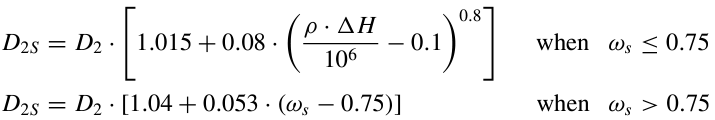
#### Stator blade number
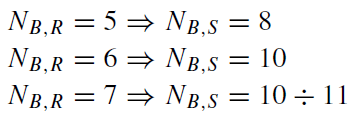

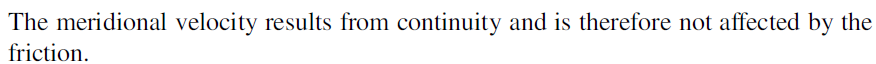

In [5]:
def statorGeo(D_2, c_2u, b_2, Nb_R, O_2, c_3, c_2, u_2, w_2, u_1, w_1, c_1, eta_hyd_R, c_p, Zh_vaneless):

    # stator geometry 

    if omega_s <= 0.75:
        if ((rho*dHs)/1e6)-0.1 < 0:
            f_ds = 1.015
        else:
            f_ds = (1.015+(0.08*(((rho*dHs)/1e6)-0.1)**0.8))
        print('f_ds: ', f_ds, '> 1.015 ? (if dHs < 100 m)')
        D_2_S = D_2*f_ds
    else:
        D_2_S = D_2*(1.04+(0.053*(omega_s-0.75)))

    print('D_2_S: ', D_2_S)

    if D_2_S - D_2 < 0.005: # acc. to Gülich min. 0.002 m (2 mm), set higher to lower friction loss
        D_2_S = D_2 + 0.005
        print('minimum diametrical clearance not achieved, set D_2_S = D_2 + 0.005 =',  D_2_S)
    else:
        print('calculated D_2_S:', D_2_S)

    b_2_S = 1.1*b_2 # more general: b_2_S = 1.05 - 1.3 * b_2

    p1 = (pt1 + (i-1)*(dtp/z)) - ((rho/2)*(c_1**2))
    print('p1: ', p1)
    p2 = p1 + eta_hyd_R*(rho/2)*((u_2**2)-(u_1**2)+(w_1**2)-(w_2**2))
    print("p2: ", p2)
    pt2 = p2 + ((rho/2)*(c_2**2))
    print('pt2: ', pt2)
    pt2S = pt2 - (Zh_vaneless*rho*g)
    print('pt2s: ', pt2S)
    pt3s = pt3 - ((z-i)*(dtp/z))
    print('pt3s: ', pt3s) # stage pt3
    p3 = (pt3 - (z-i)*(dtp/z)) - ((rho/2)*(c_3**2))
    
    c_2_Sm = V/(math.pi*D_2_S*b_2_S)

    # initial values
    c_2_Su = c_2u*(D_2/D_2_S) # absolute tangential velocity at the vaned diffuser inlet (assuming no friction?)
    c_2S = math.sqrt((c_2_Sm**2)+(c_2_Su**2))
    print('initial c_2S: ', c_2S)
    c_2S_old = c_2S + 0.1
    n_it_c_2S = 0

    while abs(c_2S-c_2S_old) > 1e-3:
        n_it_c_2S = n_it_c_2S + 1
        c_2S_old = c_2S
        p2S = p3 - (c_p*0.5*rho*(c_2S**2))
    
        c_2S = math.sqrt((2/rho)*(pt2S-p2S))
        
        if n_it_c_2S > 50:
            print('c_2S not converged!')
            break

    print('c_2S: ', c_2S)
    print('p2S: ', p2S)
    print('p3:', p3)

    c_2_Su = math.sqrt((c_2S**2)-(c_2_Sm**2))

    alpha_2_S = math.atan(c_2_Su/c_2_Sm)
    print('alpha_2_S: ', alpha_2_S, '=', alpha_2_S*(180/math.pi))

    Lm_vaneless = (D_2_S-D_2)/2

    # Stator hydraulic parameters

    L_hyd_vaneless = Lm_vaneless

    D_hyd_vaneless = b_2+b_2_S # correct?? (because D_hyd_2 not b_2 ??)

    # vaned diffuser geometry (Gülich)

    D_3 = D_2*(1.1+0.53*omega_s) # outlet diameter
    print('D_3:', D_3)

    b_3 = b_2_S # diffuser width (assumed to be constant)

    c_3m = V/(math.pi*D_3*b_3)
    print('c_3m:', c_3m)

    if abs(c_3m-c_3) < 1e-3:
        alpha_3 = 0
        print('c_3 converged, alpha_3 = ', alpha_3)
        print()
        repeat = False

    elif c_3m < (c_3-1e-3):
        alpha_3 = math.acos(c_3m/c_3)
        print('c_3 converged, alpha_3 = ', alpha_3)
        print()
        repeat = False

    else:
        print('c_3m > c_3')
        c_3 = c_3m
        alpha_3 = 0
        repeat = True
        # if this is the case -> iteration (new dH -> new omega_s -> ...)

    # add more constraints (see later in the book) ??

    Nb_S = 10 # stator blade number (to limit pressure pulsations and vibrations)

    Lm_vaned = (D_3-D_2_S)/2

    alpha_M = (alpha_2_S+alpha_3)/2
    L_hyd_vaned = Lm_vaned/math.cos(alpha_M)

    S_2_S = (math.pi*D_2_S)/Nb_S # blade pitch at stator inlet
    print('S_2_S: ', S_2_S)
    S_3 = (math.pi*D_3)/Nb_S # blade pitch at stator outlet

    sigma_S = L_hyd_vaned/S_3 # solidity

    O_2_S = S_2_S*math.cos(alpha_2_S) # blade distance at the leading edge
    O_3 = S_3*math.cos(alpha_3) # blade distance at the trailing edge

    # cross sectional areas and wetted perimeters

    A_w2_S = O_2_S*b_2_S
    P_w2_S = 2*(O_2_S+b_2_S)
    A_w3 = O_3*b_3
    P_w3 = 2*(O_3+b_3)

    D_hyd_2_S = 2*((O_2_S*b_2_S)/(O_2_S+b_2_S))
    D_hyd_3 = 2*((O_3*b_3)/(O_3+b_3))

    D_hyd_vaned = (D_hyd_2_S+D_hyd_3)/2

    A_R = (D_3*b_3*math.cos(alpha_3))/(D_2_S*b_2_S*math.cos(alpha_2_S))
    r_eq = math.sqrt((D_2_S*math.cos(alpha_2_S)*b_2_S)/Nb_S)
    A_R_opt = 1.05+(0.184*(L_hyd_vaned/r_eq))

    c_2Sq = V/(Nb_S*O_2_S*b_2_S) #Velocity at the cross sectional area (O_2S*b_2S)

    w_bar_vaneless = (2*V)/(Nb_R*O_2*b_2+Nb_S*O_2_S*b_2_S) # vaneless diffuser mean velocity (correct calculation?)

    return {'L_hyd_vaneless': L_hyd_vaneless, 'c_2Sq': c_2Sq, 'w_bar_vaneless': w_bar_vaneless, 'c_3': c_3,
            'c_2_Su': c_2_Su, 'c_2_Sm': c_2_Sm, 'D_hyd_vaned': D_hyd_vaned, 'O_2_S': O_2_S, 'b_2_S': b_2_S,
            'Nb_S': Nb_S, 'L_hyd_vaned': L_hyd_vaned, 'r_eq': r_eq, 'A_R': A_R,'A_R_opt': A_R_opt, 'repeat': repeat,
            'D_2_S': D_2_S, 'D_3': D_3, 'p1': p1, 'p2': p2, 'p2S': p2S, 'p3': p3, 'c_2S': c_2S}


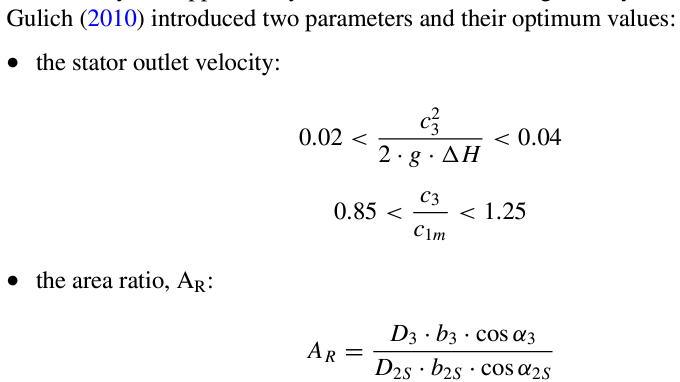

In [6]:
def admKs(w_1,c_2S, D_hyd_R, D_hyd_vaned, p1, p2S):

    # CORRECT PRESSURES (STATIC VALUES)

    # Reynolds number and roughness

    mu_1 = CP.PropsSI("V", "T", T1, "P", p1, "Propane") # [Pa*s]
    print("mu_1: ", mu_1)

    # asumption: rho = const.

    T2 = CP.PropsSI("T", "D", rho, "P", p2S, "Propane") # [K]
    print("T2: ", T2)
    mu_2S = CP.PropsSI("V", "T", T2, "P", p2S, "Propane") # [Pa*s]
    print("mu_2S: ", mu_2S)

    # Reynolds Numbers
    
    Re_1 = (rho*w_1*D_hyd_R)/mu_1
    Re_2S = (rho*c_2S*D_hyd_vaned)/mu_2S
    
    ks_adm_R = D_hyd_R*(100/Re_1)
    ks_adm_S = D_hyd_vaned*(100/Re_2S)
    
    print ('k_s < ks_adm_R =', ks_adm_R)
    print ('k_s < ks_adm_S =', ks_adm_S)
    
    return {'mu_1': mu_1, 'mu_2S': mu_2S, 'c_2S': c_2S}


## Stage losses and efficiency
### Rotor losses


In [7]:
def rotorLoss(w_1M, w_1q, u_2, mu_1, w_bar_R, L_hyd_R, b_2, D_2, D_hyd_R):

    # shock losses

    Zh_shock = 0.3*(((w_1M-w_1q)/u_2)**2)*((u_2**2)/(2*g))
    print('Zh_shock: ', Zh_shock)
    # skin friction losses

    # assumption (calculate differently?)
    mu = mu_1

    Re = (rho*w_bar_R*L_hyd_R)/mu # Reynolds number
    print('w_bar, L_hyd, Re (rotor):', w_bar_R, L_hyd_R, Re)
    f_r = 0.136/((-math.log10((0.2*(k_s/L_hyd_R))+(12.5/Re)))**(2.15))
    print('f_r(rotor):', f_r)

    f_sf = (f_r+0.0015)*(1.1+(4*(b_2/D_2))) # skin friction coefficient
    
    Zh_sf = 4*f_sf*(L_hyd_R/D_hyd_R)*((w_bar_R/u_2)**2)*((u_2**2)/(2*g)) # skin friction losses
    print('Zh_sf:', Zh_sf)
    # Rotor losses
    Zh_R = Zh_shock + Zh_sf
    
    return {'Zh_R': Zh_R}

### Stator losses

In [8]:
def statorLoss(mu_2S, w_bar_vaneless, L_hyd_vaneless, u_2, O_2_S, D_2, b_2_S, c_2m, b_2, Nb_S, c_2, c_2Sq, L_hyd_vaned, r_eq, A_R, A_R_opt, p2S, c_2S, p3):

    # stator losses

    mu = mu_2S

    Re = (rho*w_bar_vaneless*L_hyd_vaneless)/mu # Reynolds number
    print('w_bar, L_hyd, Re (stator):', w_bar_vaneless, L_hyd_vaneless, Re)

    R_crit = 1e5 # or calculate with formula (see Gülich, value for Tu?)

    if Re > R_crit:
        f_r = 0.136/((-math.log10((0.2*(k_s/L_hyd_vaneless))+(12.5/Re)))**(2.15))
    else:
        f_r = (2.65/(Re**0.875))-(2/((8*Re)+(0.016/Re)))+(1.328/(math.sqrt(Re)))

    print('f_r(stator):', f_r)

    if vanes:

        # Zh_vaneless with downstream vaned diffuser

        f_sf= f_r+0.0015 # Skin friction coefficient

        Zh_vaneless = ((u_2**2)/(2*g))*f_sf*((O_2_S/D_2)+(b_2_S/D_2))*(((math.pi**3)*((c_2m/u_2)*(b_2/D_2))**2)/(8*(Nb_S*(O_2_S/D_2)*(b_2_S/D_2))**3))*(1+(c_2/c_2Sq))**3 # Losses vaneless diffusor
        print('Zh_vaneless:', Zh_vaneless)

        # Zh_vaneless = 0 # set to zero because too high

        # losses in vaned diffuser

        # c_p =(p3-p_2_S)/(0.5*rho*c_2s**2) # pressure recovery  coefficient
        if abs(A_R-A_R_opt) < 0.1:
            c_p = 0.36*((L_hyd_vaned/r_eq)**0.26) # optimum c_p (Gulich) if A_R = A_R_opt
        else:
            c_p = (p3-p2S)/(0.5*rho*(c_2S**2))
            c_p_opt = 0.36*((L_hyd_vaned/r_eq)**0.26)
            print('c_p_opt: ', c_p_opt)
        
        c_pi = 1-(1/(A_R**2)) # ideal pressure recovery coefficient
        print('c_p, c_pi:', c_p, c_pi)
        #A_R = (O_3*b_3)/(O_2_S*b_2_S) # area ratio
        Zh_vaned = ((u_2**2)/(2*g))*(((c_2Sq/u_2)**2)*((0.3*(((c_2/c_2Sq)-1)**2))+(c_pi-c_p))) # losses in vaned diffuser
        print('Zh_vaned:', Zh_vaned)

        # stator losses
        Zh_S = Zh_vaneless + Zh_vaned

    else:

        ### Zh_vaneless without vaned diffuser

        # what about D_3, b_3, ... -> changes in geometry calculation ??
        # add variables to function
        
        Zh_shock = ((u_2**2)/(2*g))*(((c_2m/u_2)**2)*(((math.pi*D_2*math.cos(beta_2B))/(math.pi*D_2*math.cos(beta_2B)-t_b*Nb_R))-(b_2/b_2_S))**2) #Shock losses
        
        Zh_sf = ((u_2**2)/(2*g))*f_r*(D_2/(b_2_S*math.cos(alpha_2_S)*(math.sin(alpha_2_S))**2))*((c_2u/u_2)**2)*(1-(D_2/D_2_S)) #Skin friciton losses (deviation from Gülich error?)
        
        Zh_vanless = Zh_shock +Zh_sf
        Zh_S = Zh_vaneless

    return {'Zh_S': Zh_S, 'c_p': c_p, 'Zh_vaneless': Zh_vaneless}

In [9]:
# Total pump losses

def totalLoss(Zh_R, Zh_S):

    Z_h = Zh_R + Zh_S
    
    return {'Z_h': Z_h}

## Design Iteration (Thermodynamic Parameters)

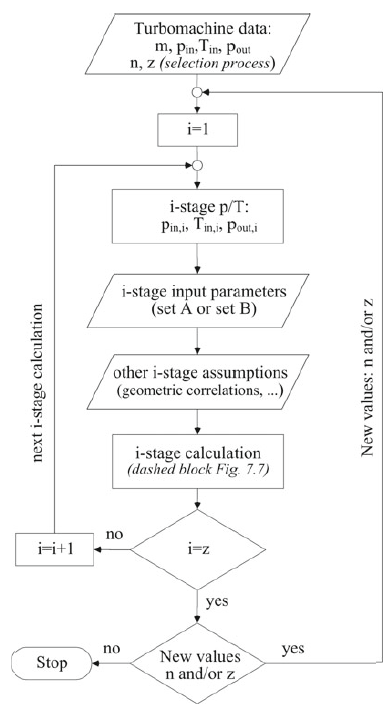 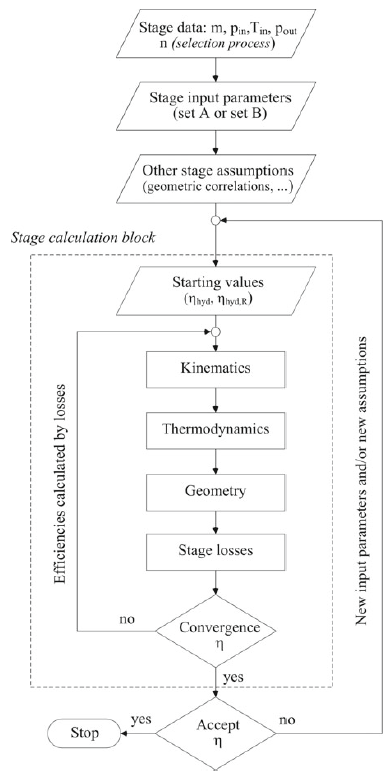 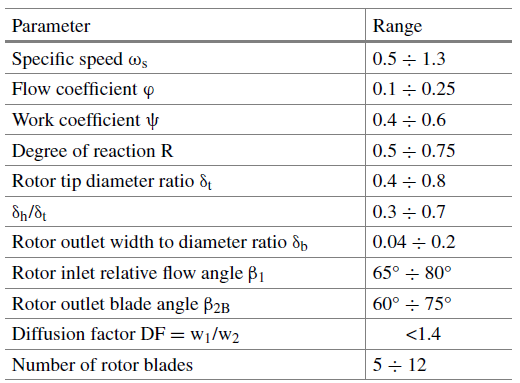

### Input Parameters (Initial Values)

In [10]:
psi = 0.7013646507747339 # avg: 0.5
phi = 0.15388582693997957 # avg: 0.175
# R < R_max (alpha_1 = 0)
R_max = 1 + ((phi**2)/(2*psi))-(psi/2)
print('R_max:', R_max)
R = 0.6644421115712987 # avg: 0.625
delta_h = 0.25
alpha_1 = 0

# inital values
eta_hyd = 0.5
eta_hyd_R = 0.5

c_1 = 0
c_p = 0.5
Zh_vaneless = 20

R_max: 0.6661996544121875


### Loop

In [11]:
stages = {'stage_{0}'.format(x): {} for x in range(1, z+1)}
print(stages)
    
dH = dtp/(rho*g)  # [m] pump head
dHs = dH/z # [m] stage head
print('dHs: ', dHs)
omega_s = ((2*math.pi*n)/60)*(math.sqrt(V)/((g*dHs)**(3/4)))
print('omega_s:', omega_s)

i = 1

while i <= z:

    stage_var = 'stage_'+str(i)
    print()
    print('calculating', stage_var, '...')

    # initial values

    stages[stage_var].update({'c_1': c_1})
    stages[stage_var].update({'phi': phi})
    stages[stage_var].update({'c_p': c_p})
    stages[stage_var].update({'Zh_vaneless': Zh_vaneless})

    repeat = True
    set_c_1 = False
    n_it_c_3 = 0

    while (repeat):

        n_it_c_3 = n_it_c_3 + 1
        print()
        print('c_3 iteration', n_it_c_3)

        if n_it_c_3 > 20:
            print('c_3 not converged')
            break

        # inital values
        eta_hyd_calc = eta_hyd
        eta_hyd_R_calc = eta_hyd_R

        eta_hyd_err = 1
        eta_hyd_R_err = 1

        n_it_eta = 0

        while eta_hyd_err > 1e-3 or eta_hyd_R_err > 1e-3:

            n_it_eta = n_it_eta + 1
            print()
            print('eta iteration', n_it_eta)

            eta_hyd_calc_old = eta_hyd_calc
            eta_hyd_R_calc_old = eta_hyd_R_calc

            if n_it_eta > 100:
                print('eta not converged')
                break

            stage_kinParam = kinParam(eta_hyd_calc, psi, stages[stage_var]['phi'], R, delta_h, alpha_1, stages[stage_var]['c_1'])
            stages[stage_var].update(stage_kinParam)
            stage_rotorGeo = rotorGeo(stages[stage_var]['c_1m'], stages[stage_var]['c_2m'], stages[stage_var]['D_2'], stages[stage_var]['delta_t'], stages[stage_var]['xi'], stages[stage_var]['beta_2'], stages[stage_var]['alpha_2'])
            stages[stage_var].update(stage_rotorGeo)
            stage_statorGeo = statorGeo(stages[stage_var]['D_2'], stages[stage_var]['c_2u'], stages[stage_var]['b_2'], stages[stage_var]['Nb_R'], stages[stage_var]['O_2'], stages[stage_var]['c_3'], stages[stage_var]['c_2'], stages[stage_var]['u_2'], stages[stage_var]['w_2'], stages[stage_var]['u_1'], stages[stage_var]['w_1'], stages[stage_var]['c_1'], eta_hyd_R_calc, stages[stage_var]['c_p'], stages[stage_var]['Zh_vaneless'])
            stages[stage_var].update(stage_statorGeo)
            print('c_3:', stages[stage_var]['c_3'])
            if stages[stage_var]['repeat'] == True:
                repeat = True
                set_c_1 = True
                stages[stage_var]['c_1'] = stages[stage_var]['c_3']
                break
            repeat = False
            set_c_1 = False
            n_it_c_3 = 0
            stage_admKs = admKs(stages[stage_var]['w_1'], stages[stage_var]['c_2S'], stages[stage_var]['D_hyd_R'], stages[stage_var]['D_hyd_vaned'], stages[stage_var]['p1'], stages[stage_var]['p2S'])
            stages[stage_var].update(stage_admKs)
            stage_rotorLoss = rotorLoss(stages[stage_var]['w_1M'], stages[stage_var]['w_1q'], stages[stage_var]['u_2'], stages[stage_var]['mu_1'],stages[stage_var]['w_bar_R'], stages[stage_var]['L_hyd_R'], stages[stage_var]['b_2'], stages[stage_var]['D_2'], stages[stage_var]['D_hyd_R'])
            stages[stage_var].update(stage_rotorLoss)
            stage_statorLoss = statorLoss(stages[stage_var]['mu_2S'], stages[stage_var]['w_bar_vaneless'], stages[stage_var]['L_hyd_vaneless'], stages[stage_var]['u_2'], stages[stage_var]['O_2_S'], stages[stage_var]['D_2'], stages[stage_var]['b_2_S'], stages[stage_var]['c_2m'], stages[stage_var]['b_2'], stages[stage_var]['Nb_S'], stages[stage_var]['c_2'], stages[stage_var]['c_2Sq'], stages[stage_var]['L_hyd_vaned'], stages[stage_var]['r_eq'], stages[stage_var]['A_R'], stages[stage_var]['A_R_opt'], stages[stage_var]['p2S'], stages[stage_var]['c_2S'], stages[stage_var]['p3'])
            stages[stage_var].update(stage_statorLoss)
            stage_totalLoss = totalLoss(stages[stage_var]['Zh_R'], stages[stage_var]['Zh_S'])
            stages[stage_var].update(stage_totalLoss)

            eta_hyd_R_calc = 1-(stages[stage_var]['Zh_R']/((((stages[stage_var]['u_2']**2)-(stages[stage_var]['u_1']**2))/(2*g))+(((stages[stage_var]['w_1']**2)-(stages[stage_var]['w_2']**2))/(2*g))))
            eta_hyd_calc = 1-((g*stages[stage_var]['Z_h'])/stages[stage_var]['W'])
            print('Zh_R:', stages[stage_var]['Zh_R'])

            print('calculated eta_hyd_R:', eta_hyd_R_calc)
            print('calculated eta_hyd:', eta_hyd_calc)
            eta_hyd_R_err = abs(eta_hyd_R_calc-eta_hyd_R_calc_old)
            eta_hyd_err = abs(eta_hyd_calc-eta_hyd_calc_old)

    print()
    print('CHECK beta_1:', stages[stage_var]['beta_1']*(180/math.pi), '= 65° - 80° ?')
    print('CHECK beta_2:', stages[stage_var]['beta_2']*(180/math.pi), '= ?')
    print('CHECK beta_2B:', stages[stage_var]['beta_2B']*(180/math.pi), '= 60° - 75° ?')
    print('CHECK D_2_S:', stages[stage_var]['D_2_S'], '>', 1.015*stages[stage_var]['D_2'], '?')
    print('CHECK w_1q/w_1M: ',stages[stage_var]['w_1q']/stages[stage_var]['w_1M'], '> 0.65 ?')
    print('CHECK:', '0.02 < c_3**2/2*g*dHs =', (stages[stage_var]['c_3']**2)/(2*g*dHs), '<', 0.04, '?')
    print('CHECK:', '0.85 < c_3/c_1m =', stages[stage_var]['c_3']/stages[stage_var]['c_1m'], '<', 1.25, '?')
    print('CHECK:', 'A_R =', stages[stage_var]['A_R'], '=', stages[stage_var]['A_R_opt'], '= A_R_opt ?')
    print('CHECK:', 'DF = w_1/w_2 =', stages[stage_var]['w_1']/stages[stage_var]['w_2'], '< 1.4 ?')
        
    i = i + 1

print (stages)



{'stage_1': {}, 'stage_2': {}}
dHs:  196.51933956685122
omega_s: 0.24486650640934743

calculating stage_1 ...

c_3 iteration 1

eta iteration 1
D_2:  0.039185870127520867
c_2:  52.13263330719499
set c_3 = c_1 = 11.409821113224133
b_2: 0.0007820046274158045
D_1h: 0.009796467531880217
D_1t: 0.011641314042887084
D_1M: 0.01071889078738365
calculated b_1: 0.0009224232555034339
beta_1M: 1.0583520178377406
SF: 0.8844598794907459
beta_2B: 76.51235493047918
SF: 0.8622182739037618
beta_2B: 75.09623043672025
SF: 0.8553139889025032
beta_2B: 74.57798564992278
SF: 0.852878903084219
beta_2B: 74.38459691198663
SF: 0.8519820092801663
beta_2B: 74.31188617102555
SF: 0.85164641274232
beta_2B: 74.28446984289332
beta_2B:  1.2965085818569233
f_ds:  1.0214749663062235 > 1.015 ? (if dHs < 100 m)
D_2_S:  0.04002738536818943
minimum diametrical clearance not achieved, set D_2_S = D_2 + 0.005 = 0.044185870127520864
p1:  290578.51874305133
p2:  1223787.4644449402
pt2:  2213791.054298113
pt2s:  2070853.4682981132
p

## Cavitation

In [12]:
# Required Net Positive Suction Head Turbomachinery p.338

#omega_s = omega *(V**0.5)/(g*delta_H)**(3/4) #Specific Speed
#omega_s = 0.27
lambda_c = -0.103*math.log(omega_s)+1.1855
lambda_w = 0.2144*math.exp(0.1745*omega_s)
w_1t = w_1 = 22.455 #Equal?
p_v_P = 9.7*1e-4
p_s = p1 = 3.085*1e5
c_s = c_1 = 8.994 #TBD?
c_1m = 8.994


NPSH_R = lambda_c*(c_1m**2)/(2*g)+lambda_w*(w_1t**2)/(2*g) # Required Net Positive Suction Head
NPSH = (p_s-p_v_P)/(rho*g)+c_s**2/(2*g) # Net positive suction head

print('NPSH_R =',NPSH_R)
print('NPSH =',NPSH)
if NPSH > NPSH_R:
    print('NPSH > NPSH_R, Cavitation avoided!)')
else:
    print('Error: NPSH <= NPSH_R, Caviation exists!')

NPSH_R = 11.235804976896617
NPSH = 47.28863079072008
NPSH > NPSH_R, Cavitation avoided!)


## Throat area


In [13]:
b_2_S = 0.0014641739286010238
c_2u = 41.97231752098456
D_2 = 0.030135797623250835
D_2_S = 0.035135797623250836
Nb_S = 10
f_a3 = 1.2 # 1.1 - 1.3 acc. to Gülich

X_Le = math.exp(V/(b_2_S*c_2u*(D_2/2)*Nb_S))
a_2_S = f_a3*(D_2_S/2)*(X_Le-1)
print('a_2_S: ', a_2_S)

alpha_2_S = 1.5050774964589333

A_2_S_q = a_2_S*b_2_S
print('A_2_S_q: ', A_2_S_q)
A_2_S = D_2_S*b_2_S*math.pi
print('A_2_S: ', A_2_S)
A_2_S_proj = D_2_S*b_2_S*math.cos(alpha_2_S)
print('A_2_S_proj: ', A_2_S_proj)

a_2_S:  0.0008225060241726949
A_2_S_q:  1.2042918767109434e-06
A_2_S:  0.00016161897909404432
A_2_S_proj:  3.3784667538955496e-06
